In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier


In [3]:

# Load and preprocess the dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering with 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_scaled)
X_kmeans = np.hstack((X_scaled, kmeans_clusters.reshape(-1, 1)))

# Perform EM clustering with 2 components
em = GaussianMixture(n_components=2, random_state=42)
em_clusters = em.fit_predict(X_scaled)
X_em = np.hstack((X_scaled, em_clusters.reshape(-1, 1)))


In [4]:

# Split the dataset
X_train_kmeans, X_test_kmeans, y_train, y_test = train_test_split(X_kmeans, y, test_size=0.2, random_state=42)
X_train_em, X_test_em, y_train, y_test = train_test_split(X_em, y, test_size=0.2, random_state=42)

In [5]:

# Function to create the neural network model
def create_model_kmeans(learning_rate=0.01):
    model = Sequential()
    model.add(Dense(8, input_dim=X_train_kmeans.shape[1], activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Function to create the neural network model
def create_model_em(learning_rate=0.01):
    model = Sequential()
    model.add(Dense(8, input_dim=X_train_em.shape[1], activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create the KerasClassifier
model_kmeans = KerasClassifier(model=create_model_kmeans, verbose=0)
model_em = KerasClassifier(model=create_model_em, verbose=0)

# Define the grid search parameters
param_grid = {
    'model__learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [10, 20, 50],
    'epochs': [50, 100, 200]
}

# Perform grid search for K-means enriched dataset
grid_kmeans = GridSearchCV(estimator=model_kmeans, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result_kmeans = grid_kmeans.fit(X_train_kmeans, y_train, callbacks=[EarlyStopping(monitor='loss', patience=3)])
print(f"Best K-means: {grid_result_kmeans.best_score_} using {grid_result_kmeans.best_params_}")


/Users/dorothy.duan/miniconda3/envs/gaml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/dorothy.duan/miniconda3/envs/gaml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/dorothy.duan/miniconda3/envs/gaml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mode

Best K-means: 0.9713895666318114 using {'batch_size': 20, 'epochs': 50, 'model__learning_rate': 0.001}


In [6]:

# Perform grid search for EM enriched dataset
grid_em = GridSearchCV(estimator=model_em, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result_em = grid_em.fit(X_train_em, y_train, callbacks=[EarlyStopping(monitor='loss', patience=3)])
print(f"Best EM: {grid_result_em.best_score_} using {grid_result_em.best_params_}")

# Evaluate each model on the test set
best_model_kmeans = grid_result_kmeans.best_estimator_
best_model_em = grid_result_em.best_estimator_

best_model_kmeans.fit(X_train_kmeans, y_train)
best_model_em.fit(X_train_em, y_train)

y_pred_kmeans = best_model_kmeans.predict(X_test_kmeans)
y_pred_em = best_model_em.predict(X_test_em)

test_accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)
test_accuracy_em = accuracy_score(y_test, y_pred_em)

print(f"K-means Test Accuracy: {test_accuracy_kmeans}")
print(f"EM Test Accuracy: {test_accuracy_em}")


/Users/dorothy.duan/miniconda3/envs/gaml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/dorothy.duan/miniconda3/envs/gaml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/dorothy.duan/miniconda3/envs/gaml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mode

Best EM: 0.9714040896944347 using {'batch_size': 50, 'epochs': 100, 'model__learning_rate': 0.001}


/Users/dorothy.duan/miniconda3/envs/gaml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/dorothy.duan/miniconda3/envs/gaml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


K-means Test Accuracy: 0.9736842105263158
EM Test Accuracy: 0.9649122807017544


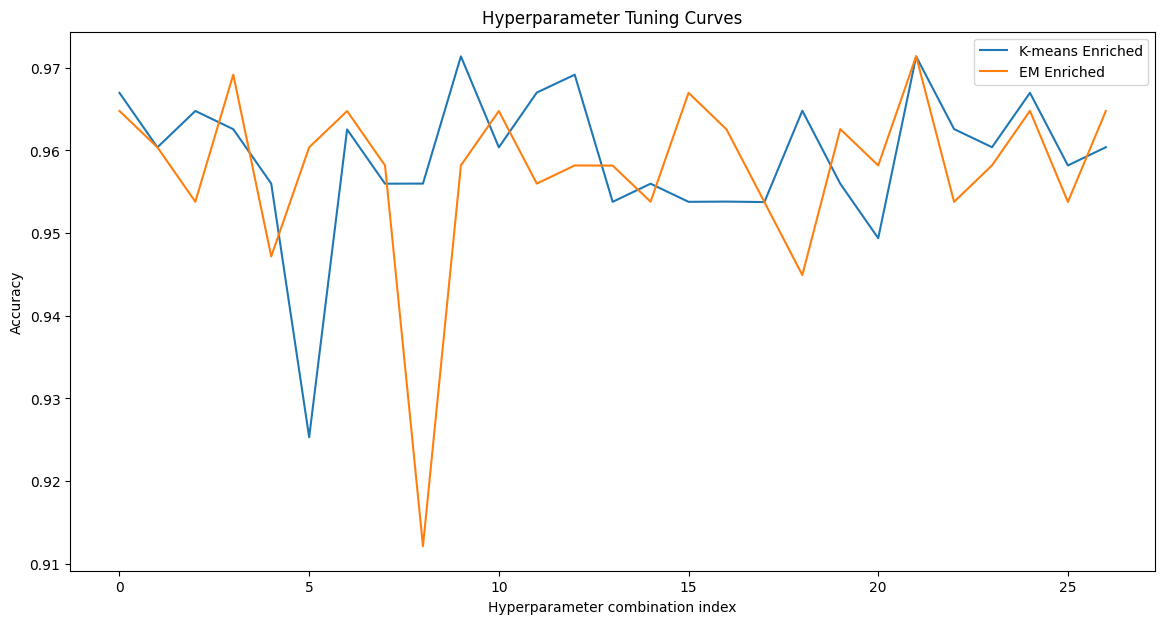

<function matplotlib.pyplot.ylim(*args, **kwargs) -> 'tuple[float, float]'>

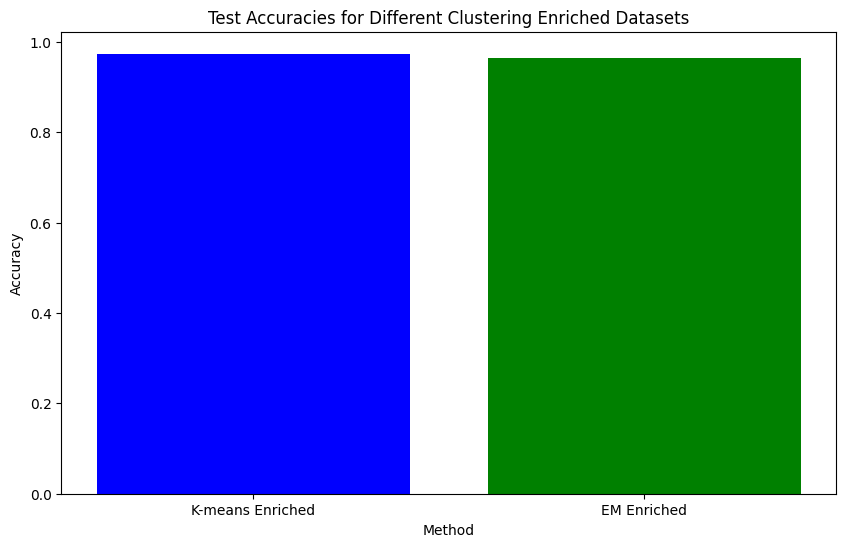

In [7]:

# Plot the hyperparameter tuning curves
plt.figure(figsize=(14, 7))

plt.plot(grid_result_kmeans.cv_results_['mean_test_score'], label='K-means Enriched')
plt.plot(grid_result_em.cv_results_['mean_test_score'], label='EM Enriched')

plt.xlabel('Hyperparameter combination index')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Tuning Curves')
plt.legend()
plt.show()

# Plot the accuracies
methods = ['K-means Enriched', 'EM Enriched']
accuracies = [test_accuracy_kmeans, test_accuracy_em]

plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color=['blue', 'green'])
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Test Accuracies for Different Clustering Enriched Datasets')
plt.ylim
